## Time Series Analysis
**This notebook is about**:
* Trying out the UK Open Data API
* Requesting data on corona virus from [GOV.UK Coronavirus(COVID-19) Open Data API](https://coronavirus.data.gov.uk/details/developers-guide/main-api)
* Doing some pretty quick and dirty data exploration
* Getting some simple statistics
* Visualising the results

### Visual Summaries in this notebook
* Regional Yearly Tally of Covid-19 Cases
* Nation-wide monthly Tally of Covid-19 Cases
* Daily Variation in the number of Covid-19 Cases
* Aggregate Tally of Covid-19 Cases by Region
* Pie Chart representing Aggregate Tally of Covid-19 Cases by Region

In [1]:
from api import get_paginated_dataset
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import json
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-whitegrid')

In [2]:
query_filters = [f'areaType=region']
query_structure = {"date": "date",
                   "name": "areaName",
                   "code": "areaCode",
                   "daily": "newCasesBySpecimenDate",
                   "cumulative": "cumCasesBySpecimenDate"
                  }

### Get the data as `csv`

In [3]:
csv_data = get_paginated_dataset(query_filters, query_structure, as_csv = True)

In [4]:
csv_lines = csv_data.split("\n")
print(f'Length: {len(csv_lines)}')
print(f'Data (first 3 lines):\n{csv_lines[:3]}')

Length: 12191
Data (first 3 lines):
['date,name,code,daily,cumulative', '2023-10-24,North West,E12000002,77,2864615', '2023-10-23,North West,E12000002,150,2864538']


**Save the data to disk**

In [5]:
data = pd.DataFrame([line.split(',') for line in csv_lines[1:]], columns = csv_lines[0].split(','))
data.to_csv('./data/data.csv', index = False)

### Load and analyse data

In [6]:
df = pd.read_csv('./data/data.csv', parse_dates = ['date'], index_col = ['date'])
df.head()

,name,code,daily,cumulative
date,,,,
2023-10-24,North West,E12000002,77,2864615
2023-10-23,North West,E12000002,150,2864538
2023-10-22,North West,E12000002,111,2864388
2023-10-21,North West,E12000002,97,2864277
2023-10-20,North West,E12000002,164,2864180


In [7]:
df.rename(columns = {'name': 'region'}, inplace = True) 
df.drop(columns = ['code'], inplace = True)
df.head()

,region,daily,cumulative
date,,,
2023-10-24,North West,77,2864615
2023-10-23,North West,150,2864538
2023-10-22,North West,111,2864388
2023-10-21,North West,97,2864277
2023-10-20,North West,164,2864180


## Regional Yearly Tally

In [8]:
regional_yearly = df.groupby('region').daily.resample('A', kind = 'period').sum().unstack()
regional_yearly.columns.names = ['year']
regional_yearly

year,2020,2021,2022,2023
region,,,,
East Midlands,196447,824623,722122,47847
East of England,216743,1021087,1007072,58594
London,422965,1532910,1163020,56973
North East,130128,458160,440308,28607
North West,388456,1355569,1049646,70944
South East,312527,1470227,1547891,91994
South West,124682,855841,975686,59556
West Midlands,243729,974340,869184,55720
Yorkshire and The Humber,265791,901551,800416,54592


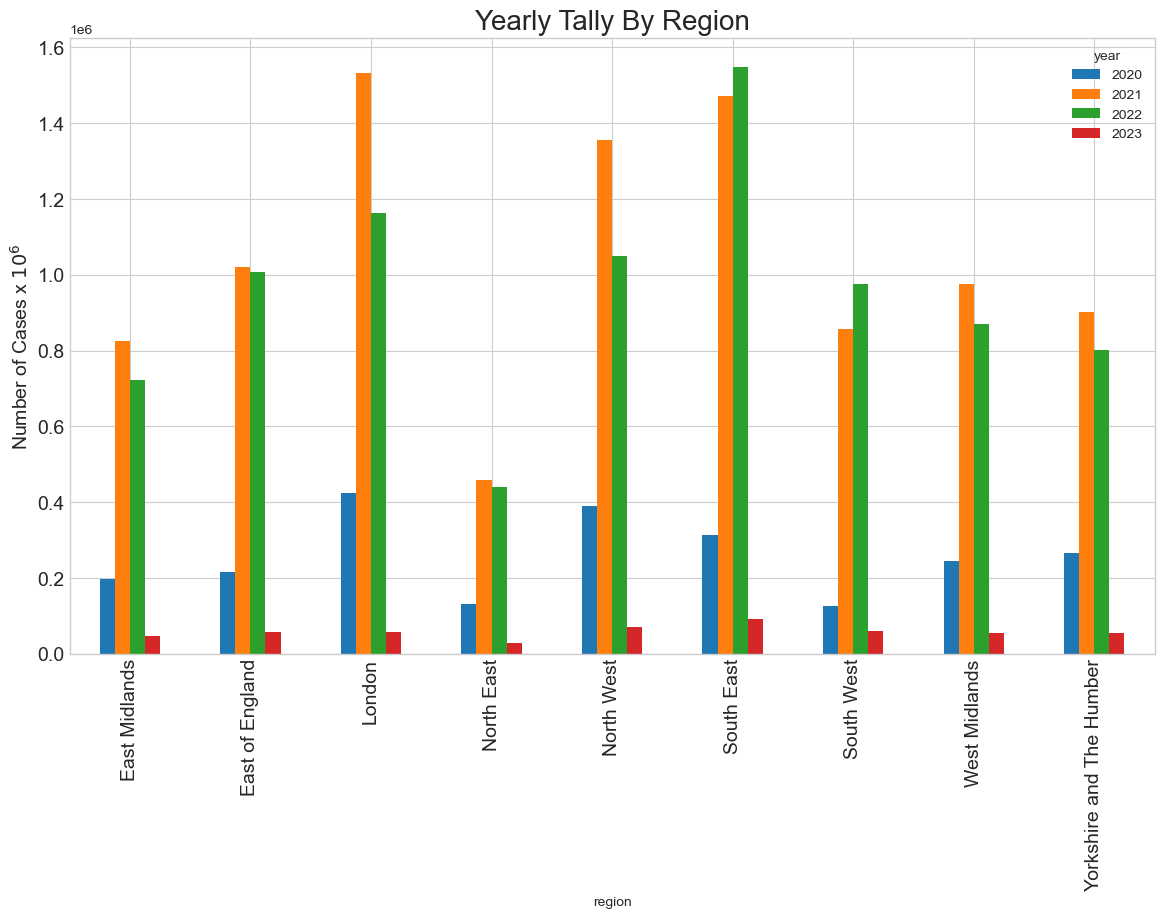

In [9]:
regional_yearly.plot(kind = 'bar', figsize = (14, 8), fontsize = 14)
plt.title('Yearly Tally By Region', fontsize = 20)
plt.ylabel('Number of Cases x $10^6$', fontsize = 14)
plt.show()

### Nation-wide monthly Tally

In [10]:
national_monthly = df.groupby(df.index.month).daily.resample('A', kind = 'period').sum().unstack().fillna(0).T
national_monthly.columns = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
national_monthly.index.names = ['year']
national_monthly.columns.names = ['month']
national_monthly

month,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
year,,,,,,,,,,,,
2020,1.0,54.0,31528.0,112508.0,66905.0,25202.0,19211.0,30064.0,127351.0,485065.0,531897.0,871682.0
2021,1101254.0,301061.0,141040.0,62829.0,64408.0,302943.0,950643.0,796032.0,776226.0,1067889.0,1024853.0,2805130.0
2022,3194643.0,1097133.0,1774998.0,649752.0,198242.0,382530.0,522816.0,149220.0,147954.0,211390.0,91029.0,155638.0
2023,81020.0,94344.0,116596.0,51215.0,31827.0,13012.0,14076.0,30814.0,53167.0,38756.0,0.0,0.0


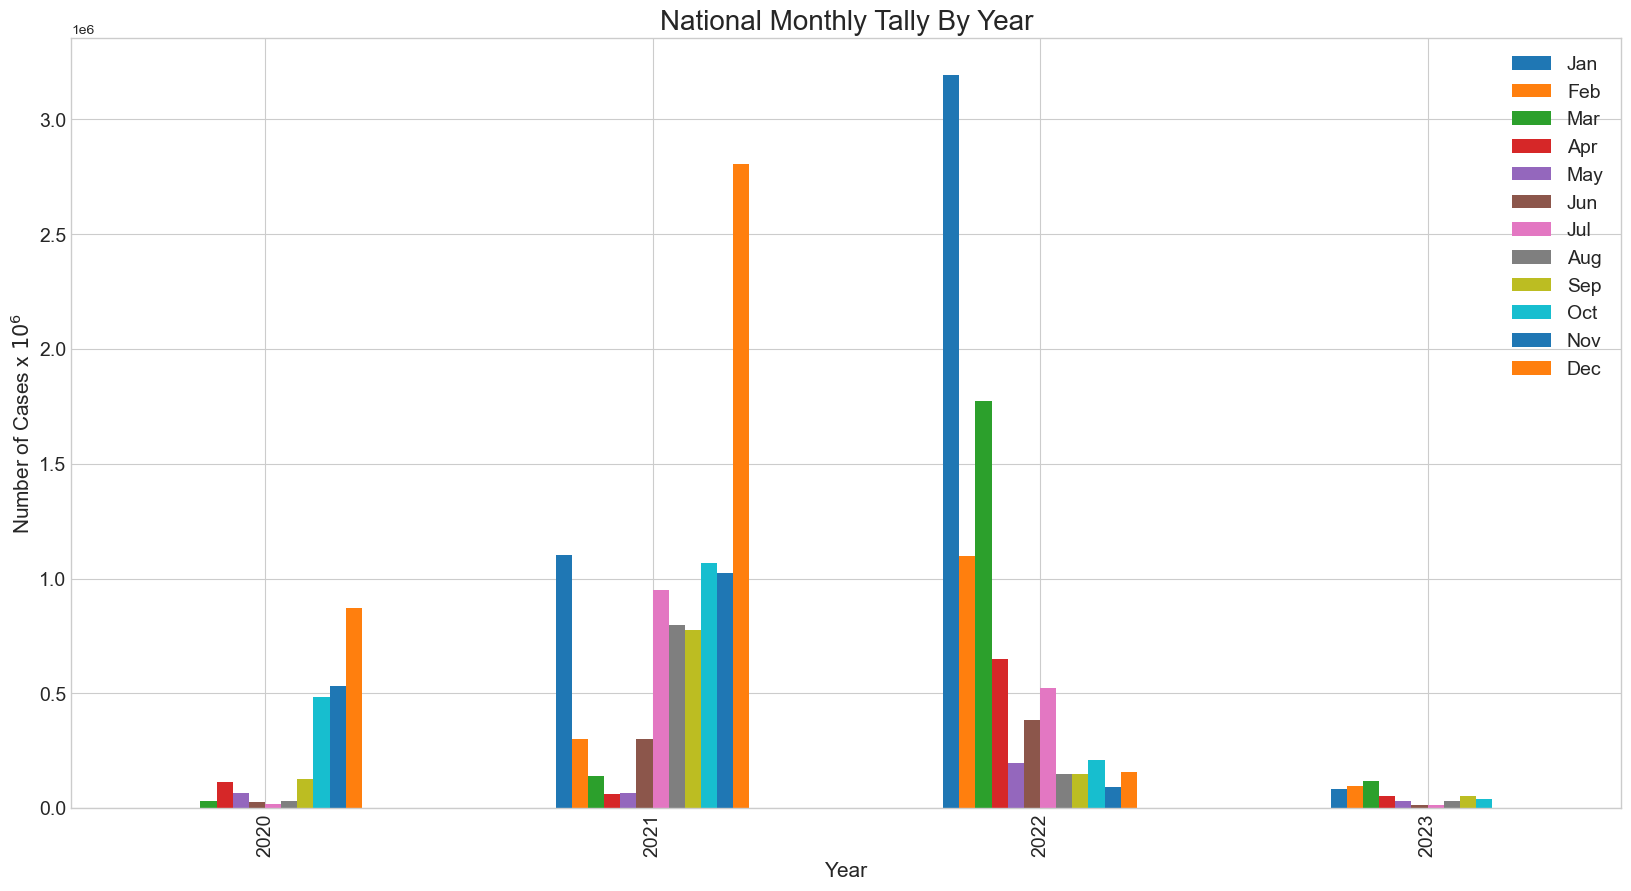

In [11]:
national_monthly.plot(kind = 'bar', figsize = (20, 10), fontsize = 14)
plt.title('National Monthly Tally By Year', fontsize = 20)
plt.legend(fontsize = 14)
plt.ylabel('Number of Cases x $10^6$', fontsize = 15)
plt.xlabel('Year', fontsize = 15)
plt.show()

* The disproportionate high cases in **December 2021 - January 2022** is due to the outbreak of the **omicron** variant. 
* There was a **general decline** in the number of cases in **Feb 2022** followed by a sudden rise in **March 2022**.
* There has been a significant drop in the number of infection since **`August 31, 2022`** with a drastic drop in **`November and December 2022`**.

**Considering the degree of prevalence of the diesease, it is highly likely that most of the positive test results in 2023 are `false positives` (FPs). It is therefore highly recommended that mandatory tests should be halted! Tests should only be conducted on patients and probably only in hospitals.**

#### National Quarterly Tally in the number of cases

In [12]:
national_quarterly = df.daily.resample("Q", kind = "period").sum().to_frame()
national_quarterly.index.names = ['Quarter']
national_quarterly

,daily
Quarter,
2020Q1,31583
2020Q2,204615
2020Q3,176626
2020Q4,1888644
2021Q1,1543355
2021Q2,430180
2021Q3,2522901
2021Q4,4897872
2022Q1,6066774


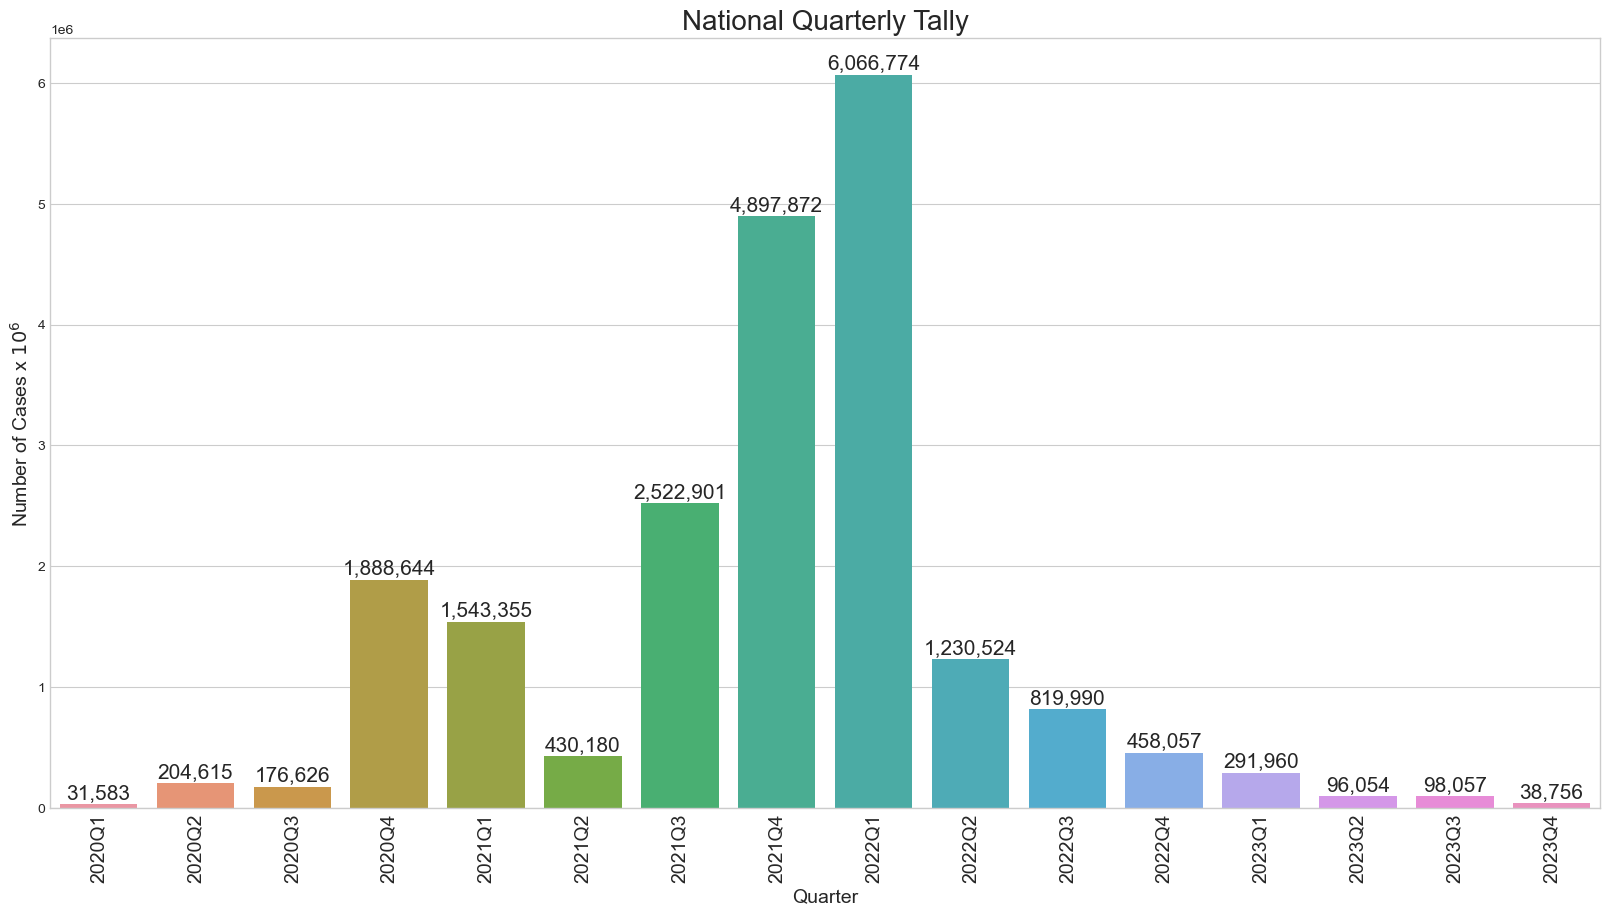

In [18]:
plt.figure(figsize = (20, 10))
plots = sns.barplot(x = national_quarterly.index, y = national_quarterly.daily)
for bar in plots.patches:
    plots.annotate(f'{bar.get_height():,.0f}',
                   (bar.get_x() + bar.get_width() / 2, bar.get_height()),    
                   ha = 'center', va = 'center',
                   size = 15, xytext = (0, 8),
                   textcoords = 'offset points')
plt.title('National Quarterly Tally', fontsize = 20)
plt.ylabel('Number of Cases x $10^6$', fontsize = 14)
plt.xlabel('Quarter', fontsize = 14)
plt.xticks(rotation = 90, fontsize = 14)
plt.show()

**Q4 in 2021 and Q1 in 2022 account for about 50% of total cases! This is the period that saw the outbreak of `Delta`and `Omicron`variants!**

#### Daily Variation in the number of cases

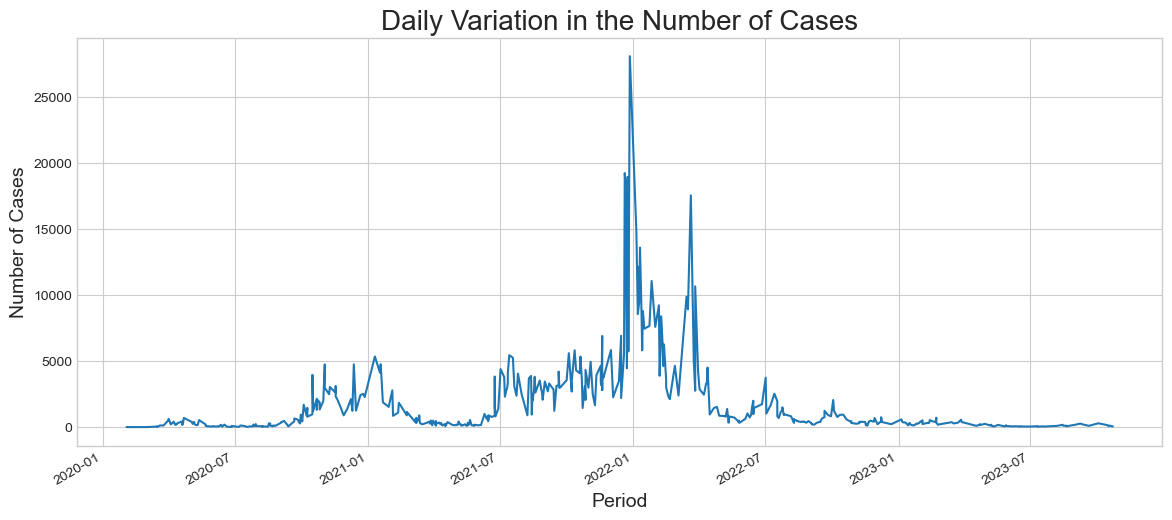

In [14]:
plt.figure(figsize = (14, 6))
df.daily.sample(500).plot()
plt.ylabel('Number of Cases', fontsize = 14)
plt.xlabel('Period', fontsize = 14)
plt.title('Daily Variation in the Number of Cases', fontsize = 20)
plt.show()

**The daily statistics agrees with the monthly tally above with spikes in the periods `December - January` which saw the outbreak of `Delta`and `Omicron`variants respectively. The curve has been relatively flat since the Q3 of 2022.** 

#### The infection rate has dropped significantly as of `November 30, 2022`

### Aggregate Tally by Region
This actually recreates the column **`cumulative`** in the data!

In [15]:
regional_agg = df.groupby(['region'])['daily'].sum().sort_values(ascending = False).to_frame()
regional_agg

,daily
region,
South East,3422639
London,3175868
North West,2864615
East of England,2303496
West Midlands,2142973
Yorkshire and The Humber,2022350
South West,2015765
East Midlands,1791039
North East,1057203


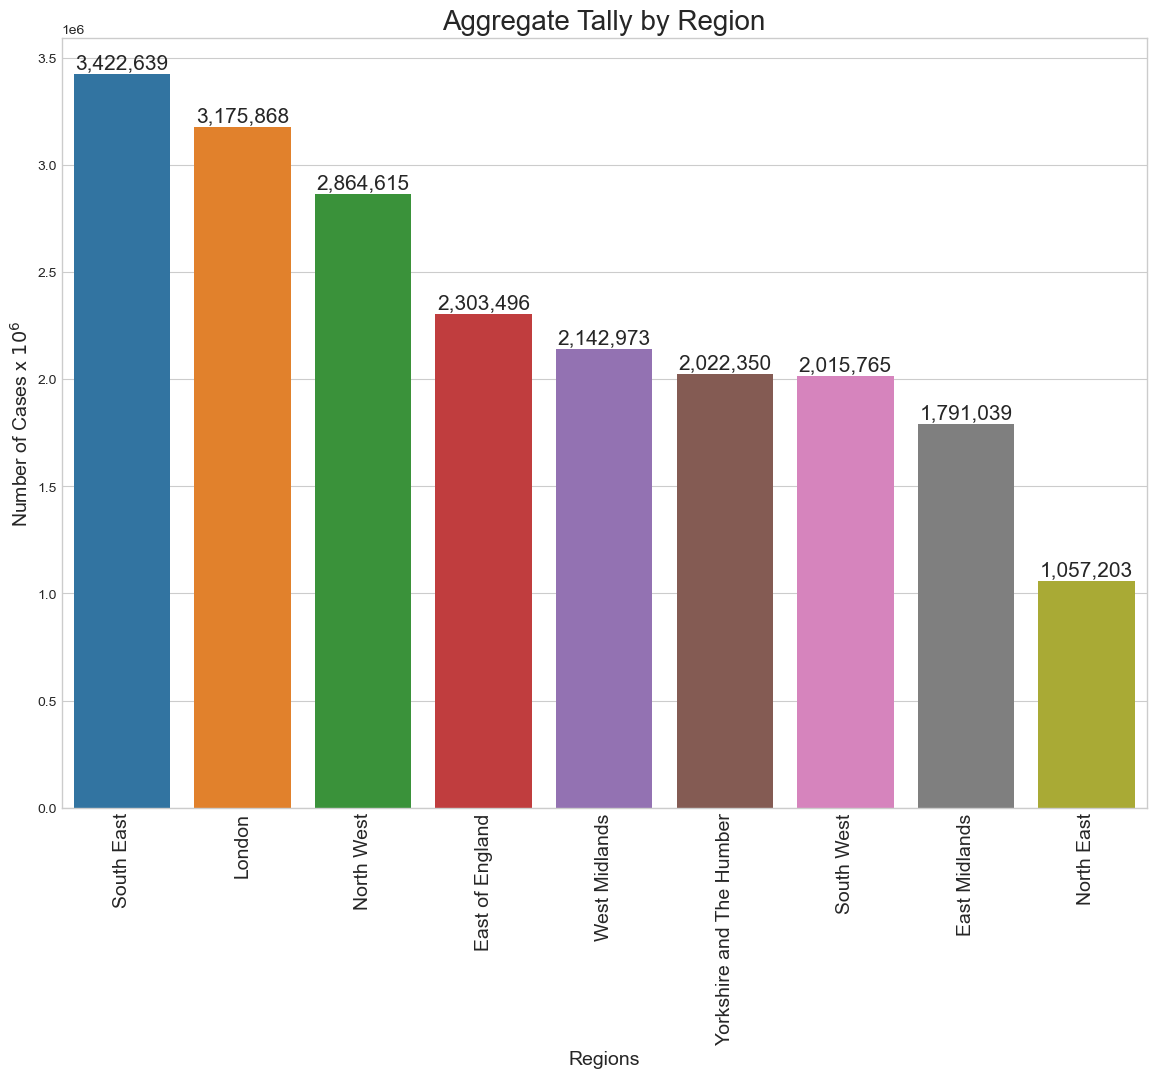

In [16]:
plt.figure(figsize = (14, 10))
plots = sns.barplot(x = regional_agg.index, y = regional_agg.daily)
for bar in plots.patches:
    plots.annotate(f'{bar.get_height():,.0f}',
                   (bar.get_x() + bar.get_width() / 2, bar.get_height()),    
                   ha = 'center', va = 'center',
                   size = 15, xytext = (0, 8),
                   textcoords = 'offset points')
plt.title('Aggregate Tally by Region', fontsize = 20)
plt.ylabel('Number of Cases x $10^6$', fontsize = 14)
plt.xlabel('Regions', fontsize = 14)
plt.xticks(rotation = 90, fontsize = 14)
plt.show()

**As can be seen on the Pareto chart, North East, the least hit region, is certain doing something different which is worth emulating...!!**

### Pie Chart representing same information as above

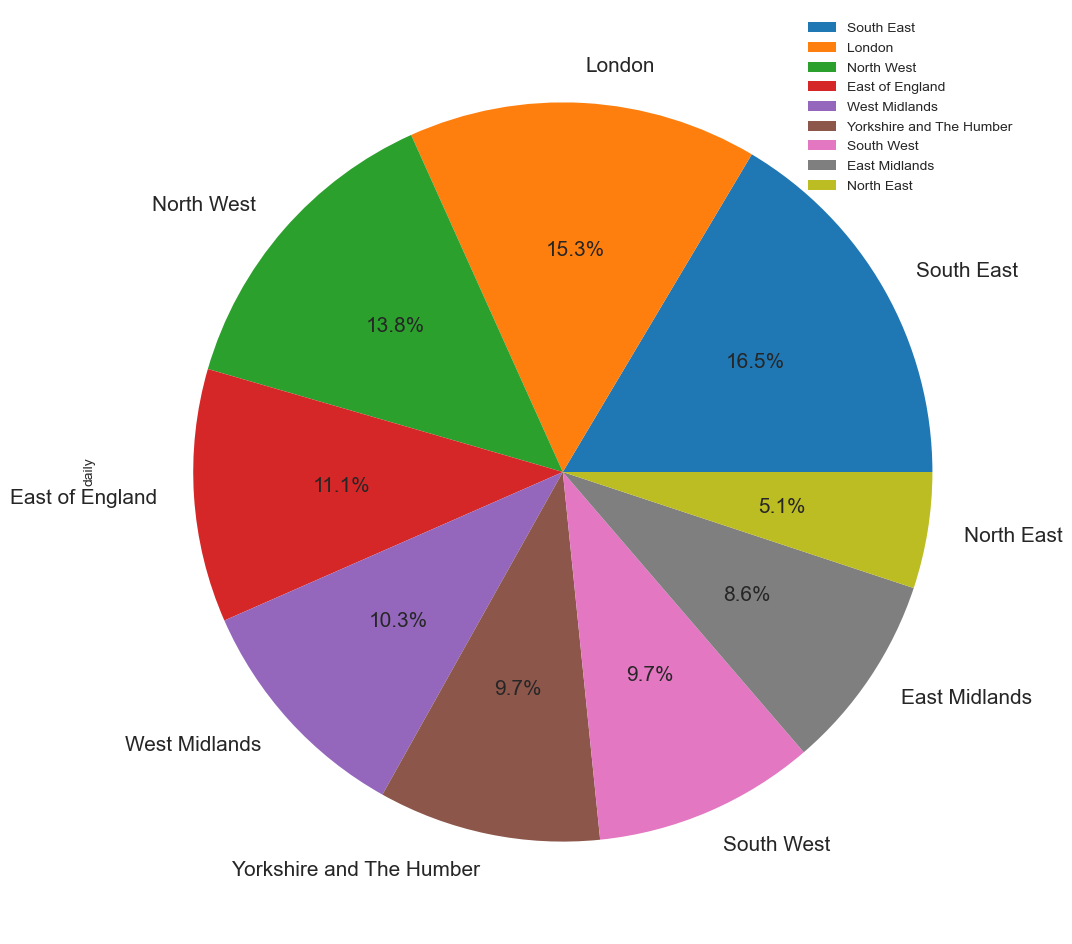

In [17]:
regional_agg.plot(kind = 'pie', subplots = True, figsize = (12, 12), autopct = '%1.1f%%', fontsize = 15)
plt.show()